In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import sys
os.chdir('/content/drive/My Drive/ProyectoIA2/generative-spectral-datasets')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np
from models.main import make_autoencoder, make_discriminator
from models.layers import Discriminatorpix2pix
import matplotlib.pyplot as plt

input_shape = (32,32,3)

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = train_images / 255

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [4]:
print(train_images.shape)

(50000, 32, 32, 3)


In [5]:
mse_loss = tf.keras.losses.MeanSquaredError()


def discriminator_loss(real_output, fake_output):
    loss = tf.math.log(real_output) + tf.math.log(1 - fake_output)
    return - tf.math.reduce_mean(loss)
    
def autoencoder_loss(real_x, estimated_x, real_output, fake_output, tau=0.001):
    autoencoder_loss = mse_loss(real_x, estimated_x)
    gan_loss =  tau*discriminator_loss(real_output, fake_output)
    total_loss = autoencoder_loss - gan_loss
    return total_loss

def discriminator_losspix2pix(disc_real_output, disc_generated_output):
  loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

A_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

FACTOR = [ 1 , 1 , 1/16 , 1/32 , 1/64, 1/256]
features= 256

A = make_autoencoder(input_shape, features=features, factors=FACTOR)

D = make_discriminator(input_shape, features=features, factors=FACTOR)
# discriminator = tf.keras.applications.mobilenet.MobileNet(input_shape=input_shape, classes=1, weights=None, classifier_activation='sigmoid')



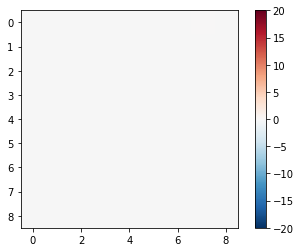

In [6]:
input_image = np.expand_dims(train_images[0, ...], axis = 0)
gen_output = A(input_image, training=False)

discriminator = Discriminatorpix2pix()
plt.imshow(gen_output[0, ...])
disc_out = discriminator([input_image, gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [7]:
images = next(iter(train_dataset))

generated_images = A(images, training=True)
print(tf.shape(generated_images))
real_output = discriminator([images, images], training=True)
fake_output = discriminator([images, generated_images], training=True)

# LOSS COMPUTING
A_loss = autoencoder_loss(images, generated_images, real_output, fake_output)
D_loss = discriminator_losspix2pix(real_output, fake_output)

print(D_loss)
print(A_loss)

tf.Tensor([256  32  32   3], shape=(4,), dtype=int32)
tf.Tensor(1.5255885, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)


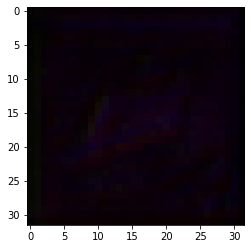

In [8]:
plt.imshow(gen_output[0, ...], vmin = np.min(gen_output), vmax = np.max(gen_output))

In [9]:
A.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
encoder (Encoder)            (None, 32, 32, 1)         424466    
_________________________________________________________________
generator (Generator)        (None, 32, 32, 3)         424470    
Total params: 848,936
Trainable params: 848,936
Non-trainable params: 0
_________________________________________________________________


In [10]:
D.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
discriminator (Discriminator (None, 32, 32, 1)         424474    
Total params: 424,474
Trainable params: 424,474
Non-trainable params: 0
_________________________________________________________________


In [11]:
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 32, 6)    0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential (Sequential)         (None, 16, 16, 64)   6144        concatenate[0][0]            

In [28]:
@tf.function
def train_step(images, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    # INFERENCE
    generated_images = A(images, training=True)
    real_output = discriminator([generated_images , images], training=True)
    fake_output = discriminator([images, generated_images], training=True)

    # LOSS COMPUTING
    A_loss = autoencoder_loss(images, generated_images, real_output, fake_output)
    D_loss = discriminator_losspix2pix(real_output, fake_output)
  # BACKPROPAGATION
  A_gradients = gen_tape.gradient(A_loss, A.trainable_variables)
  D_gradients = disc_tape.gradient(D_loss, discriminator.trainable_variables)

  A_optimizer.apply_gradients(zip(A_gradients, A.trainable_variables))
  D_optimizer.apply_gradients(zip(D_gradients, discriminator.trainable_variables))
  return A_loss , D_loss


def train(dataset, epochs):
  print("START TRAINING")
  for epoch in range(epochs):

    ae_total_loss = []
    disc_total_loss = []

    for image_batch in dataset:
      gen_loss , disc_loss = train_step(image_batch, epoch + 1)

      ae_total_loss.append(float(gen_loss))
      disc_total_loss.append(float(disc_loss))
      print("Autoencoder loss: %.4f | Discriminator loss: %.4f" % (float(gen_loss), float(np.array(disc_loss)))) 

    ae_total_loss = np.mean(ae_total_loss)
    disc_total_loss = np.mean(disc_total_loss)

    
    print("TOTAL: Autoencoder loss: %.4f | Discriminator loss: %.4f" % (float(ae_total_loss), float(np.array(disc_total_loss)))) 

  print("END TRAINING")


In [30]:
EPOCHS = 1
train(train_dataset, EPOCHS)

START TRAINING
Autoencoder loss: nan | Discriminator loss: 0.1530
Autoencoder loss: nan | Discriminator loss: 0.1843
Autoencoder loss: nan | Discriminator loss: 0.1619
Autoencoder loss: nan | Discriminator loss: 0.1456
Autoencoder loss: nan | Discriminator loss: 0.1775
Autoencoder loss: nan | Discriminator loss: 0.1486
Autoencoder loss: nan | Discriminator loss: 0.1954
Autoencoder loss: nan | Discriminator loss: 0.1532
Autoencoder loss: nan | Discriminator loss: 0.1931
Autoencoder loss: nan | Discriminator loss: 0.1498
Autoencoder loss: nan | Discriminator loss: 0.1789
Autoencoder loss: nan | Discriminator loss: 0.1565
Autoencoder loss: nan | Discriminator loss: 0.1628
Autoencoder loss: nan | Discriminator loss: 0.1377
Autoencoder loss: nan | Discriminator loss: 0.2070
Autoencoder loss: nan | Discriminator loss: 0.1510
Autoencoder loss: nan | Discriminator loss: 0.1945
Autoencoder loss: nan | Discriminator loss: 0.1558
Autoencoder loss: nan | Discriminator loss: 0.1456
Autoencoder loss

In [33]:
x = next(iter(train_dataset))

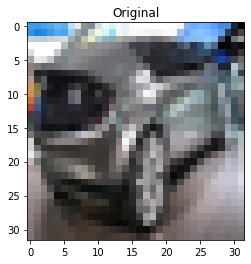

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


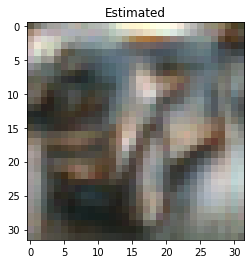

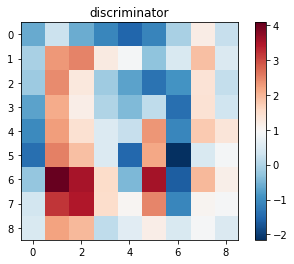

In [40]:
x_estimated = A.predict(x)

import matplotlib.pyplot as plt

num = np.random.randint(0, x.shape[0])

plt.title("Original")
plt.imshow(x[num,:,:])
plt.show()

plt.title("Estimated")
plt.imshow(x_estimated[num,:,:])
plt.show()

x_discriminator = discriminator.predict([input_image, np.expand_dims(x_estimated[num,...], axis =0)])
plt.title("discriminator")
plt.imshow(x_discriminator[0,...,-1], cmap='RdBu_r')
plt.colorbar()
plt.show()
